# Main imports and code

In [ ]:
# check which gpu we're using
!nvidia-smi

Fri Mar  4 13:13:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install simpletransformers
!pip install tensorboardx

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import numpy as np
import logging
import torch
import wandb
from collections import Counter
from ast import literal_eval

In [ ]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [ ]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2022-03-04 13:14:06.634644: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [ ]:
def eval_metrics(output, gold, print_metrics = True):
  ############################################
  # Note: Adapted from f1-measure code in lab02 solutions
  # Returns recall, precision, f1 for positive class
  ############################################
     
  test_pos_preds = np.sum(output)
  test_pos_real = np.sum(gold)
    
  pos_correct = (np.logical_and(output, gold)).astype(int)
  pos_correct = np.sum(pos_correct)
  
  precision = pos_correct / test_pos_preds
  recall = pos_correct / test_pos_real
  
  fscore = (2.0 * precision * recall) / (precision + recall)

  # Print them
  if print_metrics: 
    print(f"     Recall: {recall:.2f}, Precision: {precision:.2f}, F-measure: {fscore:.2f}")

  return recall, precision, fscore

# Fetch Don't Patronize Me! data manager module

In [ ]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [ ]:
from dont_patronize_me import DontPatronizeMe

In [ ]:
dpm = DontPatronizeMe('.', '.')

In [ ]:
dpm.load_task1()

In [ ]:
# Check the length!! Sometimes file uploads to colab get truncated. Correct value is 10469

len(dpm.train_task1_df)

10469

# Load paragraph IDs

In [ ]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [ ]:
trids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [ ]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

# Rebuild training set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
rows_orig = []
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  orig_label = int(dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]) * 25
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  rows_orig.append({
      'par_id':parid,
      'text':text,
      'label':orig_label
  })
  

In [ ]:
trdf1 = pd.DataFrame(rows)
trdf1_orig = pd.DataFrame(rows_orig)

# Rebuild test set (Task 1)

In [ ]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [ ]:
tedf1 = pd.DataFrame(rows)

## Exploratory Analysis

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np


def cramers_corrected_stat(x, y):
  """ Cramer's V statistic; uses correction from Bergsma and Wicher.
      Journal of the Korean Statistical Society 42 (2013): 323-328
  """
  conf_matrix = pd.crosstab(x, y)

  chi2 = stats.chi2_contingency(conf_matrix)[0]

  n = sum(conf_matrix.sum())
  phi2 = chi2 / n
  k, r = conf_matrix.shape
  phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))    
  rcorr = r - ((r - 1) ** 2)/ (n-1)
  kcorr = k - ((k - 1) ** 2)/ (n-1)
  result = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
  return result

In [ ]:
train_analysis_set = dpm.train_task1_df.copy()
print(train_analysis_set.columns.tolist())
train_analysis_set['text'] = train_analysis_set['text'].apply(lambda x: len(x.split()))

['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']


In [ ]:
print("Point biserial correlation between label and input length:", stats.pointbiserialr(train_analysis_set['label'], train_analysis_set['text'])[0])
print("Cramer's V between label and keyword:                 ", cramers_corrected_stat(train_analysis_set['label'], train_analysis_set['keyword']))
print("Cramer's V between label and country:                 ", cramers_corrected_stat(train_analysis_set['label'], train_analysis_set['country']))
print("Cramer's V between label and orig_label:              ", cramers_corrected_stat(train_analysis_set['label'], train_analysis_set['orig_label']))
print("Cramer's V between country and keyword:               ", cramers_corrected_stat(train_analysis_set['country'], train_analysis_set['keyword']))

Point biserial correlation between label and input length: 0.057842036425582534
Cramer's V between label and keyword:                  0.17312760725659082
Cramer's V between label and country:                  0.059372886242834155
Cramer's V between label and orig_label:               0.9998566821920264
Cramer's V between country and keyword:                0.01266812512878428


In [ ]:
print(train_analysis_set.groupby('country')['label'].value_counts(normalize=True))
print(train_analysis_set['country'].value_counts('label'))

country  label
au       0        0.931608
         1        0.068392
bd       0        0.914062
         1        0.085938
ca       0        0.913208
         1        0.086792
gb       0        0.894444
         1        0.105556
gh       0        0.856597
         1        0.143403
hk       0        0.940816
         1        0.059184
ie       0        0.903166
         1        0.096834
in       0        0.926415
         1        0.073585
jm       0        0.883673
         1        0.116327
ke       0        0.916512
         1        0.083488
lk       0        0.902778
         1        0.097222
my       0        0.921245
         1        0.078755
ng       0        0.865922
         1        0.134078
nz       0        0.909266
         1        0.090734
ph       0        0.877064
         1        0.122936
pk       0        0.902752
         1        0.097248
sg       0        0.928972
         1        0.071028
tz       0        0.901205
         1        0.098795
us       0   

In [ ]:
print(train_analysis_set.groupby('keyword')['label'].value_counts(normalize=True))
print(train_analysis_set['keyword'].value_counts('label'))

keyword        label
disabled       0        0.921206
               1        0.078794
homeless       0        0.834726
               1        0.165274
hopeless       0        0.876617
               1        0.123383
immigrant      0        0.971725
               1        0.028275
in-need        0        0.837338
               1        0.162662
migrant        0        0.966942
               1        0.033058
poor-families  0        0.834983
               1        0.165017
refugee        0        0.919476
               1        0.080524
vulnerable     0        0.925926
               1        0.074074
women          0        0.951402
               1        0.048598
Name: label, dtype: float64
migrant          0.104021
in-need          0.103353
vulnerable       0.103162
homeless         0.102875
women            0.102207
refugee          0.102015
immigrant        0.101347
disabled         0.098195
hopeless         0.095998
poor-families    0.086828
Name: keyword, dtype: float64


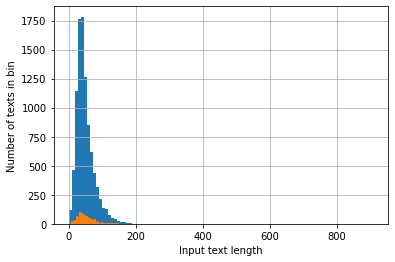

In [ ]:
x = train_analysis_set.groupby('label')['text'].hist(bins=101)
x[0].set_xlabel("Input text length")
x[0].set_ylabel("Number of texts in bin")
plt.show()

In [ ]:
pd.set_option('max_columns', None, 'max_rows', None)
train_analysis_set[train_analysis_set.columns.difference(['text'])] = train_analysis_set[train_analysis_set.columns.difference(['text'])].apply(lambda x: pd.factorize(x)[0])
print(train_analysis_set.corr())
print(train_analysis_set.groupby('keyword')['label'].value_counts(normalize=True))
#print(trdf1.groupby('country')['keyword'].value_counts(normalize=True))

              par_id    art_id   keyword   country      text     label  \
par_id      1.000000  0.964479  0.002705  0.008952 -0.005955 -0.007455   
art_id      0.964479  1.000000  0.008841 -0.013708  0.002257 -0.004429   
keyword     0.002705  0.008841  1.000000  0.012896 -0.029558  0.060319   
country     0.008952 -0.013708  0.012896  1.000000  0.026640 -0.024340   
text       -0.005955  0.002257 -0.029558  0.026640  1.000000  0.057842   
label      -0.007455 -0.004429  0.060319 -0.024340  0.057842  1.000000   
orig_label -0.007188 -0.003960  0.068098 -0.019021  0.074446  0.932998   

            orig_label  
par_id       -0.007188  
art_id       -0.003960  
keyword       0.068098  
country      -0.019021  
text          0.074446  
label         0.932998  
orig_label    1.000000  
keyword  label
0        0        0.876617
         1        0.123383
1        0        0.966942
         1        0.033058
2        0        0.971725
         1        0.028275
3        0        0.921206
   

In [ ]:
# Get label counts

print(trdf1.value_counts('label'))
print(trdf1.value_counts('label', normalize = True))

label
0    7581
1     794
dtype: int64
label
0    0.905194
1    0.094806
dtype: float64


In [ ]:
# See some samples
pd.set_option('display.max_colwidth', -1)

print("Texts tagged as CONTAINING PCL")
print(trdf1[trdf1.label == 1].sample(10, random_state=1)["text"])

print("\nTexts tagged as NOT CONTAINING PCL")
print(trdf1[trdf1.label == 0].sample(10, random_state=1)["text"])


Texts tagged as CONTAINING PCL
8      A harrowing journey Night falls early in this part of Morocco now and a cold winter looms , prompting the homeless Africans to take their chances before conditions worsen , and amid sometimes harsh treatment by authorities .                                                                                                                                                                          
551    On hunger , homelessness , disease : This is the lot of the poor and unwashed . Accepted na ( they 're expendable ) .                                                                                                                                                                                                                                                                                     
175    Even people who are disabled can still practice karate and have a sense of accomplishment . It matters not what your state of being is , people are encouraged

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


# RoBERTa Baseline for Task 1

In [ ]:
### DO NOT TOUCH

# Code is from roberta baseline colab notebook that was provided
# Reproduces baseline results
#
# We will save the predictions from here to compare with our models later

pcldf = trdf1[trdf1.label==1]
npos = len(pcldf)

training_set1 = pd.concat([pcldf,trdf1[trdf1.label==0][:npos*2]])

task1_model_args = ClassificationArgs(num_train_epochs=1, 
                                      no_save=True, 
                                      no_cache=True, 
                                      manual_seed = 1, #Added for reproducibility
                                      overwrite_output_dir=True)
task1_model = ClassificationModel("roberta", 
                                  'roberta-base',
                                  args = task1_model_args, 
                                  num_labels=2, 
                                  use_cuda=cuda_available)
task1_model.train_model(training_set1[['text', 'label']])
preds_task1, _ = task1_model.predict(tedf1.text.tolist())

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/2382 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
print(f1_score(tedf1["label"], preds_task1))
print(confusion_matrix(tedf1["label"], preds_task1, normalize="true"))

# Save results
eval_metrics(preds_task1, tedf1.label)
tedf1["roberta_base_pred"] = preds_task1

0.41466498103666244
[[0.77414248 0.22585752]
 [0.1758794  0.8241206 ]]
     Recall: 0.82, Precision: 0.28, F-measure: 0.41


In [ ]:
print("Examples of true negatives:")
print(tedf1[(tedf1["label"] == preds_task1) & (tedf1["label"] == 0)].sample(10, random_state=1)["text"])
print("Examples of true positives:")
print(tedf1[(tedf1["label"] == preds_task1) & (tedf1["label"] == 1)].sample(10, random_state=1)["text"])
print("Examples of false positives:")
print(tedf1[(tedf1["label"] != preds_task1) & (tedf1["label"] == 0)].sample(10, random_state=1)["text"])
print("Examples of false negatives:")
print(tedf1[(tedf1["label"] != preds_task1) & (tedf1["label"] == 1)].sample(10, random_state=1)["text"])

Examples of true negatives:
1504    "Calling the DNA findings "" revolutionary "" , Alfons Kennis said : "" People will be surprised ... and maybe it gets rid of the idea that you have to look a certain way to be from somewhere . We are all immigrants . """                                                                                                                                                                                                                                                                                                                                                                                                                    
1042    """ I think Pakistani artistes are being careful right now . They realise that the situation is so vulnerable that anything they say can be twisted and will spiral out of control ."                                                                                                                                                     

# Data Augmentation - Synonym Replacement

In [ ]:
from nltk.corpus import wordnet, stopwords
import nltk
import random

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

def do_synonym_replacement_augmentation(df, words_to_replace=0, multiple_to_add_positive=8, multiple_to_add_negative=2, multiple_to_add_025=0, multiple_to_add_05=0, multiple_to_add_075=0):
    if multiple_to_add_positive != 0: 
      to_add = df.loc[df.index.repeat(multiple_to_add_positive)]
      to_add = to_add[to_add.label == 1]
      to_add['text'] = to_add['text'].apply(synonym_replacement, n = words_to_replace)
      df = pd.concat([df, to_add])
    if multiple_to_add_negative != 0:
      to_add = df.loc[df.index.repeat(multiple_to_add_negative)]
      to_add = to_add[to_add.label == 0]
      to_add['text'] = to_add['text'].apply(synonym_replacement, n = words_to_replace)
      df = pd.concat([df, to_add])
    if multiple_to_add_025 != 0:
      to_add = df.loc[df.index.repeat(multiple_to_add_025)]
      to_add = to_add[to_add.label == 0.25]
      to_add['text'] = to_add['text'].apply(synonym_replacement, n = words_to_replace)
      df = pd.concat([df, to_add])
    if multiple_to_add_05 != 0:
      to_add = df.loc[df.index.repeat(multiple_to_add_05)]
      to_add = to_add[to_add.label == 0.5]
      to_add['text'] = to_add['text'].apply(synonym_replacement, n = words_to_replace)
      df = pd.concat([df, to_add])
    if multiple_to_add_075 != 0:
      to_add = df.loc[df.index.repeat(multiple_to_add_075)]
      to_add = to_add[to_add.label == 0.75]
      to_add['text'] = to_add['text'].apply(synonym_replacement, n = words_to_replace)
      df = pd.concat([df, to_add])

    return df.sample(frac = 1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Prep - Dataset Balancing

In [ ]:
def enforce_max_ratio(trdf, max_ratio = 2):
  max_size = trdf['label'].value_counts().max()
  lst = [trdf]
  for class_index, group in trdf.groupby('label'):
      lst.append(group.sample(max_size-len(group), replace=True))
  frame_new = pd.concat(lst)
  return frame_new

# Hyperparameter Tuning

In [ ]:
# Separate validation set for use in hyperparameter search
# 25% of train set ~= 20% of total training data

# Hyperparameter tuning loop will use trdf2 for training and vadf2 for validation. 
# Other training runs can use the full trdf1
n = len(trdf1)
cutoff = int(np.round(n * 0.75))
np.random.seed(1)
indices = np.random.permutation(n)
trdf2, vadf2 = trdf1.loc[indices[:cutoff,]], trdf1.loc[indices[cutoff:,],]

n = len(trdf1_orig)
cutoff = int(np.round(n * 0.75))
np.random.seed(1)
indices = np.random.permutation(n)
trdf2_orig, vadf2_orig = trdf1_orig.loc[indices[:cutoff,]], trdf1_orig.loc[indices[cutoff:,],]

In [ ]:
### CONFIGURE OPTIONS HERE

sweep_config = {
    "method": "random",  # bayes, grid, random
    "metric": {"name": "my_val_f1", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"values": [3, 5]},
        "learning_rate": {"values": [1e-5, 2e-5, 3e-5, 5e-5]},
        "train_batch_size": {"values": [64]},      

        #Augmentation
        "multiple_to_add_positive": {"values": [4]},
        "multiple_to_add_negative": {"values": [2]},
        "words_to_replace": {"values": [8]},

        # Other Stuff
        "model": {"values": [ ["roberta", "roberta-base"], 
                             ["xlnet", "xlnet-base-cased"]]},
        "max_ratio": {"values": [2]}, 
        "use_regression": {"values": [True]}
    },
}

sweep_id = wandb.sweep(sweep_config, project="Random Sweep Paul 10")

Create sweep with ID: uxngo61j
Sweep URL: https://wandb.ai/the-tuners/Random%20Sweep%20Paul%2010/sweeps/uxngo61j


In [ ]:
model_args = ClassificationArgs(no_save=True, 
                                      no_cache=True, 
                                      overwrite_output_dir=True)
model_args.manual_seed = 1
model_args.use_multiprocessing = True
model_args.labels_list = [0, 1]

In [ ]:
def train():
    # Initialize a new wandb run
    torch.cuda.empty_cache()
    wandb.init()
    model_args = ClassificationArgs(no_save=True, no_cache=True, overwrite_output_dir=True)
    model_args.manual_seed = 1
    model_args.use_multiprocessing = True
    model_args.train_batch_size = wandb.config['train_batch_size']
    model_args.eval_batch_size = wandb.config['train_batch_size']

    # Prepare Train Data
    if wandb.config["use_regression"]:
      model_args.regression = True
      eval_set = vadf2_orig
      num_labels = 1
      training_set = do_synonym_replacement_augmentation(trdf2_orig, words_to_replace = wandb.config['words_to_replace'], 
                                                       multiple_to_add_positive = wandb.config['multiple_to_add_positive'],
                                                       multiple_to_add_negative = wandb.config['multiple_to_add_negative'],
                                                       multiple_to_add_025 = wandb.config['multiple_to_add_positive'],
                                                       multiple_to_add_05 = wandb.config['multiple_to_add_positive'],
                                                       multiple_to_add_075 = wandb.config['multiple_to_add_positive'])
    else:
      eval_set = vadf2
      num_labels = 2
      training_set = do_synonym_replacement_augmentation(trdf2, words_to_replace = wandb.config['words_to_replace'], 
                                                       multiple_to_add_positive = wandb.config['multiple_to_add_positive'],
                                                       multiple_to_add_negative = wandb.config['multiple_to_add_negative'])
    training_set = enforce_max_ratio(training_set, max_ratio = wandb.config["max_ratio"])

    # Create a TransformerModel
    model = ClassificationModel(
        wandb.config["model"][0],
        wandb.config["model"][1],
        use_cuda=cuda_available,
        args=model_args,
        num_labels=num_labels,
        sweep_config=wandb.config,
    )

    # Train the model
    model.train_model(training_set[["text", "label"]])

    # Evaluate the model on validation set
    original_preds, raw_outputs = model.predict(eval_set.text.tolist())

    print(original_preds)
    if wandb.config["use_regression"]:
      original_preds[original_preds <= 37.5] = 0
      original_preds[original_preds > 37.5] = 1

    recall, precision, f1 = eval_metrics(original_preds, vadf2.label)
    
    if not wandb.config["use_regression"]:
      cutoff = 0
      for i in range(60):
        threshold = (-1.5 + i*0.05)
        tmp = [1 if x[1] > threshold else 0 for x in raw_outputs]
        tmp_recall, tmp_precision, tmp_f1 = eval_metrics(tmp, vadf2.label, print_metrics = False)
        if tmp_f1 > f1: 
          recall, precision, f1 = tmp_recall, tmp_precision, tmp_f1
          cutoff = threshold

    wandb.log({'my_val_precision': precision, 'my_val_recall': recall, 'my_val_f1': f1, 'prediction_cutoff': cutoff})

    # Evaluate the model on test set
    if wandb.config["use_regression"]:
      _, raw_outputs = model.predict(tedf1.text.tolist())
      updated_pred = [1 if x[1] > 37.5 else 0 for x in raw_outputs]
      recall, precision, f1 = eval_metrics(updated_pred, tedf1.label)
    else:  
      _, raw_outputs = model.predict(tedf1.text.tolist())
      updated_pred = [1 if x[1] > cutoff else 0 for x in raw_outputs]
      recall, precision, f1 = eval_metrics(updated_pred, tedf1.label)

    if f1 != f1:
      f1 = 0
    wandb.log({'my_test_precision': precision, 'my_test_recall': recall, 'my_test_f1': f1})

    # Sync wandb
    wandb.join()

In [38]:
wandb.agent(sweep_id, train)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=None
wandb: Agent Starting Run: 0j6bojh4 with config:
wandb: 	learning_rate: 2e-05
wandb: 	max_ratio: 2
wandb: 	model: ['roberta', 'roberta-base']
wandb: 	multiple_to_add_negative: 2
wandb: 	multiple_to_add_positive: 4
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 64
wandb: 	use_regression: True
wandb: 	words_to_replace: 8
wandb: Currently logged in as: the-tuners (use `wandb login --relogin` to force relogin)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/76650 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/1198 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 5:   0%|          | 0/1198 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/1198 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/1198 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/1198 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[-3.73291016e-01  1.70288086e-02 -3.83056641e-01 ...  2.48437500e+01
  2.44687500e+01  5.24062500e+01]
     Recall: 0.67, Precision: 0.38, F-measure: 0.48



Training loss,▇▇█▅▅▄▄▄▅▃▅▃▄▂▃▄▃▂▂▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▂▅████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Training loss,650.87817
global_step,5950
lr,0.0


Run 0j6bojh4 errored: UnboundLocalError("local variable 'cutoff' referenced before assignment")
wandb: ERROR Run 0j6bojh4 errored: UnboundLocalError("local variable 'cutoff' referenced before assignment")
wandb: Agent Starting Run: s82zs030 with config:
wandb: 	learning_rate: 1e-05
wandb: 	max_ratio: 2
wandb: 	model: ['roberta', 'roberta-base']
wandb: 	multiple_to_add_negative: 2
wandb: 	multiple_to_add_positive: 4
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 64
wandb: 	use_regression: True
wandb: 	words_to_replace: 8


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

  0%|          | 0/76650 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/1198 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/1198 [00:00<?, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


### Final Model

In [39]:
task1_model_args = ClassificationArgs(num_train_epochs=3, 
                                      train_batch_size=64,
                                      learning_rate=2e-5,
                                      regression=True,
                                      no_save=True, 
                                      no_cache=True, 
                                      manual_seed = 1,
                                      overwrite_output_dir=True)

training_set = do_synonym_replacement_augmentation(trdf1_orig, words_to_replace = 8, 
                                                   multiple_to_add_positive=4, 
                                                   multiple_to_add_negative=2)
training_set = enforce_max_ratio(training_set, max_ratio = 10)

task1_model = ClassificationModel("xlnet", 
                                  "xlnet-base-cased",
                                  args = task1_model_args, 
                                  num_labels=1, 
                                  use_cuda=cuda_available)

# train model
task1_model.train_model(training_set[['text', 'label']].sample(frac = 1))



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

  0%|          | 0/102375 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/1600 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1600 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1600 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.


(4800, 1402.600374317169)

In [45]:
# Evaluate on test set
preds, probs = task1_model.predict(tedf1.text.tolist())
preds[preds <= 37.5] = 0
preds[preds > 37.5] = 1
recall, precision, f1 = eval_metrics(preds, tedf1.label)

# Save outputs
tedf1["final_preds_classifier"] = preds

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2094 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

     Recall: 0.76, Precision: 0.31, F-measure: 0.44


# Modelling Approach 2 - Textual Entailment

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/nli-distilroberta-base')
tokenizer = AutoTokenizer.from_pretrained('cross-encoder/nli-distilroberta-base')
model.eval()

#text_features = tokenizer(list(tedf1.text), padding=True, truncation=True, return_tensors="pt")

targets = [
           'We can learn from suffering.',
           'Suffering is good.',
           'Suffering is educational.',
           'Someone helps the weak.',
           'A small action makes a difference.',
           'A small action solves a problem', 
           'Someone needs help.',
            'Educate the vulnerable.',
            'Educate those in need',
            'The needy do not know what they need',
            'The needy are ignorant',
            'The poor cannot help themselves',
            'There is an advantaged and a disadvantaged group.',
            'A huge help is given.',
            'To be poor is good', 
            'To be vulnerable is good'
]

scorelist = []

with torch.no_grad():
  for t in targets: 
    print(t)
    target_features = tokenizer(list(trdf1.text), [t]*len(trdf1.text), padding=True, truncation=True, return_tensors="pt")
    scores = model(**target_features).logits
    scorelist.append(scores)
    s = t.replace(' ', '').replace('.', '')    
    trdf1[s+'_pos'] = scores[:, 1]
    trdf1[s+'_neg'] = scores[:, 0]
#    label_mapping = ['contradiction', 'entailment', 'neutral']
#    labels = [label_mapping[score_max] for score_max in scores.argmax(dim=1)]
#    print(labels)

We can learn from suffering.


tcmalloc: large alloc 1428078592 bytes == 0x56530c882000 @  0x7f809eec6b6b 0x7f809eee6379 0x7f7f6e798cde 0x7f7f6e79a452 0x7f7fc07c1cf3 0x7f7fc07c2867 0x7f7fc07c2fe0 0x7f7fc0829b46 0x7f7fc082b6f6 0x7f7fc0f234c2 0x7f7fc0b3e296 0x7f7fc0617780 0x7f7fc1018f8e 0x7f7fc0e5a2b3 0x7f7fc2682d29 0x7f7fc2683305 0x7f7fc0e96ddf 0x7f8069de0968 0x5652041cd390 0x5652041cd120 0x565204241679 0x56520423c02f 0x5652041ceaba 0x5652042412c0 0x5652041cef19 0x5652041cf571 0x56520423e633 0x56520423c02f 0x5652041cf151 0x565204212a79 0x5652041cdb32
tcmalloc: large alloc 1428078592 bytes == 0x565361a6e000 @  0x7f809eec6b6b 0x7f809eee6379 0x7f7f6e798cde 0x7f7f6e79a452 0x7f7fc07c1cf3 0x7f7fc07c2867 0x7f7fc07c2fe0 0x7f7fc0829b46 0x7f7fc082b6f6 0x7f7fc0f234c2 0x7f7fc0b3e296 0x7f7fc0617780 0x7f7fc1018f8e 0x7f7fc0e5a2b3 0x7f7fc2682d29 0x7f7fc2683305 0x7f7fc0e96ddf 0x7f8069de0968 0x5652041cd390 0x5652041cd120 0x565204241679 0x56520423c02f 0x5652041ceaba 0x5652042412c0 0x5652041cef19 0x5652041cf571 0x56520423e633 0x56520423

Suffering is good.
Suffering is educational.
Someone helps the weak.
A small action makes a difference.
A small action solves a problem
Someone needs help.
Educate the vulnerable.
Educate those in need
The needy do not know what they need
The needy are ignorant
The poor cannot help themselves
There is an advantaged and a disadvantaged group.
A huge help is given.
To be poor is good
To be vulnerable is good


In [ ]:
for c in tedf1.columns: 
#  print(c)
  if type(tedf1[c][0]) != str:
    print(c, tedf1.label.corr(tedf1[c]))

label 1.0
Wecanlearnfromsuffering_pos 0.179585878496497
Wecanlearnfromsuffering_neg -0.028278571038093222
Sufferingisgood_pos 0.23254724901756968
Sufferingisgood_neg -0.029696031987848037
Sufferingiseducational_pos 0.17841195824325573
Sufferingiseducational_neg -0.07798386325570653
Someonehelpstheweak_pos 0.2013277062356612
Someonehelpstheweak_neg -0.11204674104823362
Asmallactionmakesadifference_pos 0.09230837212523994
Asmallactionmakesadifference_neg -0.014787306735876204
Asmallactionsolvesaproblem_pos 0.13044454870573485
Asmallactionsolvesaproblem_neg -0.06405889371287922
Someoneneedshelp_pos 0.15306839161826058
Someoneneedshelp_neg -0.08371900223826292
Educatethevulnerable_pos 0.23942171842302776
Educatethevulnerable_neg -0.15300461903113596
Educatethoseinneed_pos 0.2349987302125221
Educatethoseinneed_neg -0.16047682513056155
Theneedydonotknowwhattheyneed_pos 0.15268255759391106
Theneedydonotknowwhattheyneed_neg -0.044909451959773104
Theneedyareignorant_pos 0.11266210342040708
Then

In [ ]:
from sklearn.neural_network import MLPClassifier

colnames = [] 
for c in tedf1.columns: 
  if type(tedf1[c][0]) != str and c != "label":
    colnames.append(c)
print(colnames)

X = tedf1[colnames]
y = tedf1["label"]
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1, max_iter = 4000)

clf.fit(X, y)

['Wecanlearnfromsuffering_pos', 'Wecanlearnfromsuffering_neg', 'Sufferingisgood_pos', 'Sufferingisgood_neg', 'Sufferingiseducational_pos', 'Sufferingiseducational_neg', 'Someonehelpstheweak_pos', 'Someonehelpstheweak_neg', 'Asmallactionmakesadifference_pos', 'Asmallactionmakesadifference_neg', 'Asmallactionsolvesaproblem_pos', 'Asmallactionsolvesaproblem_neg', 'Someoneneedshelp_pos', 'Someoneneedshelp_neg', 'Educatethevulnerable_pos', 'Educatethevulnerable_neg', 'Educatethoseinneed_pos', 'Educatethoseinneed_neg', 'Theneedydonotknowwhattheyneed_pos', 'Theneedydonotknowwhattheyneed_neg', 'Theneedyareignorant_pos', 'Theneedyareignorant_neg', 'Thepoorcannothelpthemselves_pos', 'Thepoorcannothelpthemselves_neg', 'Thereisanadvantagedandadisadvantagedgroup_pos', 'Thereisanadvantagedandadisadvantagedgroup_neg', 'Ahugehelpisgiven_pos', 'Ahugehelpisgiven_neg', 'Tobepoorisgood_pos', 'Tobepoorisgood_neg', 'Tobevulnerableisgood_pos', 'Tobevulnerableisgood_neg']


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=4000,
              random_state=1, solver='lbfgs')

In [ ]:
probs = clf.predict_proba(X)
recall, precision, f1 = 0, 0, 0

cutoff = 0
for i in range(60):
  threshold = (-1.5 + i*0.05)
  tmp = [1 if x[1] > threshold else 0 for x in probs]
  tmp_recall, tmp_precision, tmp_f1 = eval_metrics(tmp, tedf1.label, print_metrics = False)
  if tmp_f1 > f1: 
    recall, precision, f1 = tmp_recall, tmp_precision, tmp_f1
    cutoff = threshold

print(cutoff, recall, precision, f1)

tedf1["final_preds_nli"] = [1 if x[1] > cutoff else 0 for x in probs]

0.25 0.6231155778894473 0.5 0.5548098434004475


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


# Examine results

In [ ]:
column_name = "final_preds"
# column_name = "roberta_base_pred"

tedf1["correct"] = tedf1[column_name] == tedf1["label"]
if ("orig_label" in tedf1.columns) == False:
  tedf1["orig_label"] = tedf1.merge(dpm.train_task1_df[["par_id", "orig_label"]], on = "par_id")["orig_label"]
if ("keyword" in tedf1.columns) == False:
  tedf1["keyword"] = tedf1.merge(dpm.train_task1_df[["par_id", "keyword"]], on = "par_id")["keyword"]
if ("country" in tedf1.columns) == False:
  tedf1["country"] = tedf1.merge(dpm.train_task1_df[["par_id", "country"]], on = "par_id")["country"]

print("Overall scores:")
eval_metrics(tedf1[column_name], tedf1["label"])

print("\n\nMetrics by text length")
tedf1["num-tokens"] = tedf1["text"].apply(lambda x: len(x.split()))
tedf1["num-tokens-quartile"] = pd.qcut(tedf1["num-tokens"], 4, labels = False)

for i in range(4):
  tmp = tedf1[tedf1["num-tokens-quartile"] == i]
  minwords = min(tmp["num-tokens"])
  maxwords = max(tmp["num-tokens"])
  recall, precision, f1 = eval_metrics(tmp[column_name], tmp["label"], print_metrics = False)
  accuracy = np.mean(tmp["correct"])
  print(f"Quartile {i+1} ({minwords:3d} - {maxwords:3d} words) : Recall: {recall:.2f}, Precision:{precision:.2f}, F1:{f1:.2f}, Accuracy:{accuracy:.2f}")

print("\n\nMetrics by level of PCL")
for i in range(5):
  tmp = tedf1[tedf1["orig_label"] == str(i)]
  accuracy = np.mean(tmp["correct"])
  print(f"PCL Score {i} (Samples: {len(tmp):4d}) : Accuracy:{accuracy:.2f}")


print("\n\nMetrics by keyword")
for class_index, group in tedf1.groupby('keyword'):
  tmp = tedf1[tedf1.keyword == class_index]
  accuracy = np.mean(tmp["correct"])
  print(f"{class_index} (Samples: {len(tmp):4d}) : Accuracy:{accuracy:.2f}")

print("\n\nMetrics by country")
for class_index, group in tedf1.groupby('country'):
  tmp = tedf1[tedf1.country == class_index]
  accuracy = np.mean(tmp["correct"])
  print(f"{class_index} (Samples: {len(tmp):4d}) : Accuracy:{accuracy:.2f}")

KeyError: ignored